In [6]:
import pandas as pd
import os
import numpy as np

os.environ["SPARK_HOME"] = "/Users/admin/Personal/Code/spark-3.5.0-bin-hadoop3"
# os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3"
# os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"

In [7]:
from pyspark.sql import SparkSession
from pyspark import SparkConf

conf = SparkConf()
# conf.set("spark.pyspark.python", "/usr/bin/python3")
# conf.set("spark.pyspark.driver.python", "/usr/bin/python3")
conf.set("spark.driver.memory", "6g")
conf.set("spark.executor.memory", "6g")

spark = SparkSession.builder \
    .master("local[6]") \
    .config(conf=conf) \
    .appName("audio-classification") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/06 01:34:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [8]:
pd_df = pd.read_pickle('./data/dataframe.pkl')
# pd_df['id'] = range(len(pd_df))
# pd_df.reset_index(inplace=True, drop=True)
pd_df

,audio_file_path,filename,original_duration,rms,category,log_attack_time,temporal_centroid,temporal_centroid_duration,lat_tc_ratio,release,...,mfcc_9_loudest,mfcc_9_d_mean,mfcc_10_mean,mfcc_10_loudest,mfcc_10_d_mean,mfcc_11_mean,mfcc_11_loudest,mfcc_11_d_mean,start_time,end_time
0,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,IF_SnareRoll_128-07,1.875011,0.098641,snare,0.217120,0.563922,41472,0.385017,4608,...,15.378702,-0.074229,5.897816,13.561751,-0.108041,5.241121,12.108868,-0.083428,0.0,0.142381
1,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,IF_SnareRoll_128-06,1.875011,0.093530,snare,0.217120,0.544064,41472,0.399070,4608,...,14.948626,-0.316963,6.361793,13.407518,-0.315865,5.712490,13.240988,-0.214229,0.0,0.242154
2,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,IF_SnareRoll_128-04,1.875011,0.110270,snare,-0.311919,0.499177,41472,-0.624867,30208,...,16.459290,-0.272491,6.513550,13.287388,-0.356275,6.019804,13.039479,-0.313585,0.0,0.326961
3,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,IF_SnareRoll_128-05,1.875011,0.097318,snare,-0.142777,0.555816,41472,-0.256878,25088,...,15.391160,-0.097382,5.498207,12.738569,-0.075195,4.920002,12.575926,-0.078373,0.0,0.481610
4,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,IF_SnareRoll_128-01,1.875011,0.098822,snare,0.217120,0.524218,40448,0.414179,3584,...,16.827457,-0.555044,7.434295,15.469650,-0.503293,6.537287,13.956232,-0.413480,0.0,0.247143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,Mun Roe ( DB ) Narcos Hi Hat 4,0.051066,0.033709,hi-hat,-1.634139,0.203337,2560,-8.036619,1536,...,-0.183746,-0.698274,-1.528620,-1.227754,0.601733,1.066248,1.121670,0.110844,0.0,NaN
1996,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,Mun Roe ( DB ) Narcos Hi Hat 5,0.046349,0.122058,hi-hat,-1.935169,0.190047,1536,-10.182562,1024,...,4.689425,-2.136645,4.410723,5.190823,-1.560199,-4.954051,-6.363052,2.818004,0.0,NaN
1997,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,Mun Roe ( DB ) Bongo Perc 2,0.156961,0.140765,bongo,-1.634139,0.163651,3072,-9.985537,2048,...,-16.751713,4.350732,-11.335248,-19.431931,4.660953,-13.235212,-22.450739,5.383870,0.0,NaN
1998,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,Mun Roe ( DB ) Bongo Perc 3,0.355556,0.103747,bongo,-1.935169,0.033202,7168,-58.284950,6656,...,-14.784551,6.159667,-13.345679,-16.883228,7.075098,-13.745396,-17.753944,8.017098,0.0,NaN


In [9]:
pd_df.columns

Index(['audio_file_path', 'filename', 'original_duration', 'rms', 'category',
       'log_attack_time', 'temporal_centroid', 'temporal_centroid_duration',
       'lat_tc_ratio', 'release', 'g_mean_rms', 'g_std_rms', 'g_zcr_rms',
       'mean_rms', 'std_rms', 'max_rms', 'mean_zcr', 'std_zcr',
       'zcr_at_rms_peak', 'crest_factor', 'log_spec_cent_mean',
       'log_spec_cent_std', 'log_spec_cent_peak', 'log_spec_cent_g_mean',
       'leg_spec_cent_g_std', 'log_spec_cent_g_zcr', 'spec_band_mean',
       'spec_band_std', 'spec_band_peak', 'spec_band_g_mean', 'spec_flat_mean',
       'spec_flat_max', 'spec_flat_min', 'spec_flat_std', 'spec_flat_peak',
       'log_spec_rolloff_15_peak', 'log_spec_rolloff_15_max',
       'log_spec_rolloff_15_min', 'log_spec_rolloff_85_peak',
       'log_spec_rolloff_85_max', 'log_spec_rolloff_85_min', 'mfcc_0_mean',
       'mfcc_0_loudest', 'mfcc_0_d_mean', 'mfcc_1_mean', 'mfcc_1_loudest',
       'mfcc_1_d_mean', 'mfcc_2_mean', 'mfcc_2_loudest', 'mfcc_2_d_

In [10]:
rows_with_nan = pd_df[pd_df.isna().any(axis=1)]
rows_with_nan

,audio_file_path,filename,original_duration,rms,category,log_attack_time,temporal_centroid,temporal_centroid_duration,lat_tc_ratio,release,...,mfcc_9_loudest,mfcc_9_d_mean,mfcc_10_mean,mfcc_10_loudest,mfcc_10_d_mean,mfcc_11_mean,mfcc_11_loudest,mfcc_11_d_mean,start_time,end_time
68,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,Snow Lefty Tom,0.594104,0.242114,tom,-1.634139,0.240926,4096,-6.782741,3072,...,53.572746,-1.800732,25.843645,51.657692,-1.592103,25.008400,49.527603,-1.366670,0.002698,NaN
69,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,Snow Right Tom,0.594104,0.237975,tom,-1.634139,0.253551,3584,-6.445012,2560,...,53.811996,-3.928532,25.452454,51.614391,-3.467546,24.595579,49.656677,-3.056485,0.000000,NaN
70,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,Snow Wide Snap,0.594104,0.027316,snap,-1.634139,0.340621,2048,-4.797529,1024,...,0.552055,-0.338946,0.591699,0.191097,-0.801205,-1.112846,-1.213948,-0.202205,0.002698,NaN
71,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,Snow Smash Crowd Clap,0.594104,0.132822,clap,-1.333109,0.353951,3584,-3.766360,2048,...,-13.826558,1.935609,-7.985457,-15.961778,0.464811,-8.623932,-16.288651,-0.914339,0.000000,NaN
72,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,Snow Turn Apart Snare,0.891111,0.280217,snare,-1.634139,0.124075,8192,-13.170521,7168,...,47.428493,-0.889117,13.846289,44.404247,-0.643916,12.976629,42.350506,-0.504203,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,Mun Roe ( DB ) Narcos Hi Hat 4,0.051066,0.033709,hi-hat,-1.634139,0.203337,2560,-8.036619,1536,...,-0.183746,-0.698274,-1.528620,-1.227754,0.601733,1.066248,1.121670,0.110844,0.000000,NaN
1996,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,Mun Roe ( DB ) Narcos Hi Hat 5,0.046349,0.122058,hi-hat,-1.935169,0.190047,1536,-10.182562,1024,...,4.689425,-2.136645,4.410723,5.190823,-1.560199,-4.954051,-6.363052,2.818004,0.000000,NaN
1997,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,Mun Roe ( DB ) Bongo Perc 2,0.156961,0.140765,bongo,-1.634139,0.163651,3072,-9.985537,2048,...,-16.751713,4.350732,-11.335248,-19.431931,4.660953,-13.235212,-22.450739,5.383870,0.000000,NaN
1998,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,Mun Roe ( DB ) Bongo Perc 3,0.355556,0.103747,bongo,-1.935169,0.033202,7168,-58.284950,6656,...,-14.784551,6.159667,-13.345679,-16.883228,7.075098,-13.745396,-17.753944,8.017098,0.000000,NaN


In [11]:
from pyspark.sql.functions import count, desc

spark_df = spark.createDataFrame(pd_df)

spark_df.groupBy('category').count().orderBy(desc('count')).show()

+--------+-----+
|category|count|
+--------+-----+
|   snare|  631|
|    kick|  372|
|    clap|  343|
|  hi-hat|  243|
|open-hat|  143|
|     tom|   92|
|   crash|   72|
|  shaker|   54|
|   bongo|   26|
|    snap|   21|
|    ride|    3|
+--------+-----+



In [12]:
from sklearn.model_selection import train_test_split

string_columns = ['audio_file_path', 'filename', 'category']
numeric_columns = [col for col in list(spark_df.columns) if col not in string_columns]
# train_df, test_df = spark_df.randomSplit([0.7,0.3], seed=4000)

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)
spark_df.show(1)

+--------------------+-------------------+------------------+-------------------+--------+------------------+------------------+--------------------------+-----------------+-------+--------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+---------------+------------------+------------------+-------------------+------------------+--------------------+-------------------+-------------------+-----------------+--------------------+------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+------------------------+-----------------------+-----------------------+------------------------+-----------------------+-----------------------+------------------+----------------+-------------------+------------------+------------------+--------------------+-----------------+-----------------+--------------------+-----

In [13]:
from pyspark.ml.feature import Imputer

imputer = Imputer()
imputed_columns = [f'imp_{col}' for col in numeric_columns]
imputer.setInputCols(numeric_columns)
imputer.setOutputCols(imputed_columns)
imputer_model = imputer.fit(spark_df)
imputed_df = imputer_model.transform(spark_df)
# imputer.fit(train_df)
# train_df = imputer.transform(train_df)
# rows_with_nan = train_df[train_df.isna().any(axis=1)]
# rows_with_nan
imputed_df.show(1)

+--------------------+-------------------+------------------+-------------------+--------+------------------+------------------+--------------------------+-----------------+-------+--------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+---------------+------------------+------------------+-------------------+------------------+--------------------+-------------------+-------------------+-----------------+--------------------+------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+------------------------+-----------------------+-----------------------+------------------------+-----------------------+-----------------------+------------------+----------------+-------------------+------------------+------------------+--------------------+-----------------+-----------------+--------------------+-----

In [14]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=imputed_columns, outputCol='features')
assembled_df = assembler.transform(imputed_df)


standard_scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scaled_df = standard_scaler.fit(assembled_df).transform(assembled_df)
scaled_df

DataFrame[audio_file_path: string, filename: string, original_duration: double, rms: double, category: string, log_attack_time: double, temporal_centroid: double, temporal_centroid_duration: bigint, lat_tc_ratio: double, release: bigint, g_mean_rms: double, g_std_rms: double, g_zcr_rms: double, mean_rms: double, std_rms: double, max_rms: double, mean_zcr: double, std_zcr: double, zcr_at_rms_peak: double, crest_factor: double, log_spec_cent_mean: double, log_spec_cent_std: double, log_spec_cent_peak: double, log_spec_cent_g_mean: double, leg_spec_cent_g_std: double, log_spec_cent_g_zcr: double, spec_band_mean: double, spec_band_std: double, spec_band_peak: double, spec_band_g_mean: double, spec_flat_mean: double, spec_flat_max: double, spec_flat_min: double, spec_flat_std: double, spec_flat_peak: double, log_spec_rolloff_15_peak: double, log_spec_rolloff_15_max: double, log_spec_rolloff_15_min: double, log_spec_rolloff_85_peak: double, log_spec_rolloff_85_max: double, log_spec_rolloff_8

In [15]:
from pyspark.ml.feature import StringIndexer

string_indexer = StringIndexer(inputCol="category", outputCol="label")
string_indexer_model = string_indexer.fit(scaled_df)
indexed_df = string_indexer_model.transform(scaled_df)
indexed_df.columns

['audio_file_path',
 'filename',
 'original_duration',
 'rms',
 'category',
 'log_attack_time',
 'temporal_centroid',
 'temporal_centroid_duration',
 'lat_tc_ratio',
 'release',
 'g_mean_rms',
 'g_std_rms',
 'g_zcr_rms',
 'mean_rms',
 'std_rms',
 'max_rms',
 'mean_zcr',
 'std_zcr',
 'zcr_at_rms_peak',
 'crest_factor',
 'log_spec_cent_mean',
 'log_spec_cent_std',
 'log_spec_cent_peak',
 'log_spec_cent_g_mean',
 'leg_spec_cent_g_std',
 'log_spec_cent_g_zcr',
 'spec_band_mean',
 'spec_band_std',
 'spec_band_peak',
 'spec_band_g_mean',
 'spec_flat_mean',
 'spec_flat_max',
 'spec_flat_min',
 'spec_flat_std',
 'spec_flat_peak',
 'log_spec_rolloff_15_peak',
 'log_spec_rolloff_15_max',
 'log_spec_rolloff_15_min',
 'log_spec_rolloff_85_peak',
 'log_spec_rolloff_85_max',
 'log_spec_rolloff_85_min',
 'mfcc_0_mean',
 'mfcc_0_loudest',
 'mfcc_0_d_mean',
 'mfcc_1_mean',
 'mfcc_1_loudest',
 'mfcc_1_d_mean',
 'mfcc_2_mean',
 'mfcc_2_loudest',
 'mfcc_2_d_mean',
 'mfcc_3_mean',
 'mfcc_3_loudest',
 'mfcc

In [16]:
train_df, test_df = indexed_df.randomSplit([0.7,0.3], seed=4000)
train_df.columns

['audio_file_path',
 'filename',
 'original_duration',
 'rms',
 'category',
 'log_attack_time',
 'temporal_centroid',
 'temporal_centroid_duration',
 'lat_tc_ratio',
 'release',
 'g_mean_rms',
 'g_std_rms',
 'g_zcr_rms',
 'mean_rms',
 'std_rms',
 'max_rms',
 'mean_zcr',
 'std_zcr',
 'zcr_at_rms_peak',
 'crest_factor',
 'log_spec_cent_mean',
 'log_spec_cent_std',
 'log_spec_cent_peak',
 'log_spec_cent_g_mean',
 'leg_spec_cent_g_std',
 'log_spec_cent_g_zcr',
 'spec_band_mean',
 'spec_band_std',
 'spec_band_peak',
 'spec_band_g_mean',
 'spec_flat_mean',
 'spec_flat_max',
 'spec_flat_min',
 'spec_flat_std',
 'spec_flat_peak',
 'log_spec_rolloff_15_peak',
 'log_spec_rolloff_15_max',
 'log_spec_rolloff_15_min',
 'log_spec_rolloff_85_peak',
 'log_spec_rolloff_85_max',
 'log_spec_rolloff_85_min',
 'mfcc_0_mean',
 'mfcc_0_loudest',
 'mfcc_0_d_mean',
 'mfcc_1_mean',
 'mfcc_1_loudest',
 'mfcc_1_d_mean',
 'mfcc_2_mean',
 'mfcc_2_loudest',
 'mfcc_2_d_mean',
 'mfcc_3_mean',
 'mfcc_3_loudest',
 'mfcc

In [24]:
from pyspark.ml.classification import RandomForestClassifier

forest_classifier = RandomForestClassifier(numTrees=6, minInstancesPerNode=2, featuresCol='scaled_features', labelCol='label')
fc_model = forest_classifier.fit(train_df)


In [25]:
predictions_df = fc_model.transform(test_df)
predictions_df.columns

['audio_file_path',
 'filename',
 'original_duration',
 'rms',
 'category',
 'log_attack_time',
 'temporal_centroid',
 'temporal_centroid_duration',
 'lat_tc_ratio',
 'release',
 'g_mean_rms',
 'g_std_rms',
 'g_zcr_rms',
 'mean_rms',
 'std_rms',
 'max_rms',
 'mean_zcr',
 'std_zcr',
 'zcr_at_rms_peak',
 'crest_factor',
 'log_spec_cent_mean',
 'log_spec_cent_std',
 'log_spec_cent_peak',
 'log_spec_cent_g_mean',
 'leg_spec_cent_g_std',
 'log_spec_cent_g_zcr',
 'spec_band_mean',
 'spec_band_std',
 'spec_band_peak',
 'spec_band_g_mean',
 'spec_flat_mean',
 'spec_flat_max',
 'spec_flat_min',
 'spec_flat_std',
 'spec_flat_peak',
 'log_spec_rolloff_15_peak',
 'log_spec_rolloff_15_max',
 'log_spec_rolloff_15_min',
 'log_spec_rolloff_85_peak',
 'log_spec_rolloff_85_max',
 'log_spec_rolloff_85_min',
 'mfcc_0_mean',
 'mfcc_0_loudest',
 'mfcc_0_d_mean',
 'mfcc_1_mean',
 'mfcc_1_loudest',
 'mfcc_1_d_mean',
 'mfcc_2_mean',
 'mfcc_2_loudest',
 'mfcc_2_d_mean',
 'mfcc_3_mean',
 'mfcc_3_loudest',
 'mfcc

In [26]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions_df)
accuracy

0.7672849915682968

In [27]:
from pyspark.sql.functions import col, when, sum, count, desc
from pyspark.ml.feature import IndexToString

label_converter = IndexToString(inputCol="prediction", outputCol="prediction_label", labels=string_indexer_model.labels)

predictions_with_labels = label_converter.transform(predictions_df)
predictions_with_labels.select(['prediction_label']).show(3)

predictions_with_accuracy = predictions_with_labels.withColumn(
    "is_correct",
    when(col("prediction_label") == col("category"), 1).otherwise(0)
)

accuracy_per_category = (predictions_with_accuracy.groupBy("category")
                         .agg(
                             (sum("is_correct") / count("is_correct")).alias("accuracy"))
                         .orderBy(desc('accuracy')))
accuracy_per_category.show()

+----------------+
|prediction_label|
+----------------+
|           snare|
|           snare|
|           snare|
+----------------+
only showing top 3 rows

+--------+-------------------+
|category|           accuracy|
+--------+-------------------+
|    kick| 0.9734513274336283|
|   snare| 0.8601036269430051|
|  hi-hat| 0.7866666666666666|
|open-hat|               0.75|
|    clap| 0.6808510638297872|
|     tom| 0.4642857142857143|
|   crash|0.43478260869565216|
|  shaker|0.17647058823529413|
|    snap|                0.0|
|   bongo|                0.0|
+--------+-------------------+



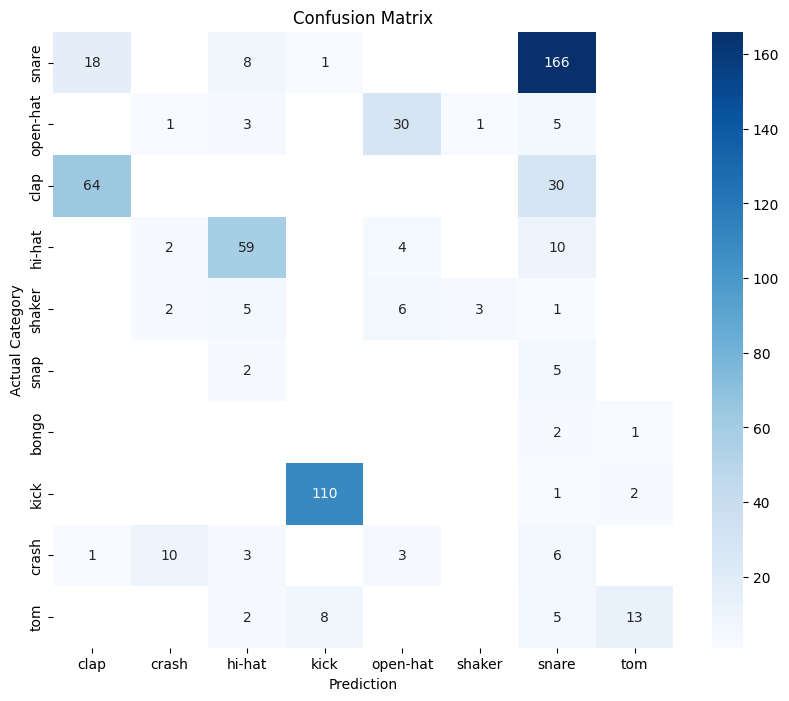

In [28]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

confusion_matrix_df = (predictions_with_labels
                       .groupBy("category")
                       .pivot("prediction_label")
                       .count())
confusion_matrix_pd = confusion_matrix_df.toPandas()
confusion_matrix_pd = confusion_matrix_pd.set_index("category")

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_pd, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual Category')
plt.xlabel('Prediction')
plt.show()

In [32]:
from pyspark.ml.classification import RandomForestClassifier

importances = fc_model.featureImportances
importances_list = importances.toArray().tolist()

feature_importance_df = pd.DataFrame(list(zip(numeric_columns, importances_list)),
                                     columns=["Feature", "Importance"]).sort_values(by="Importance", ascending=False)

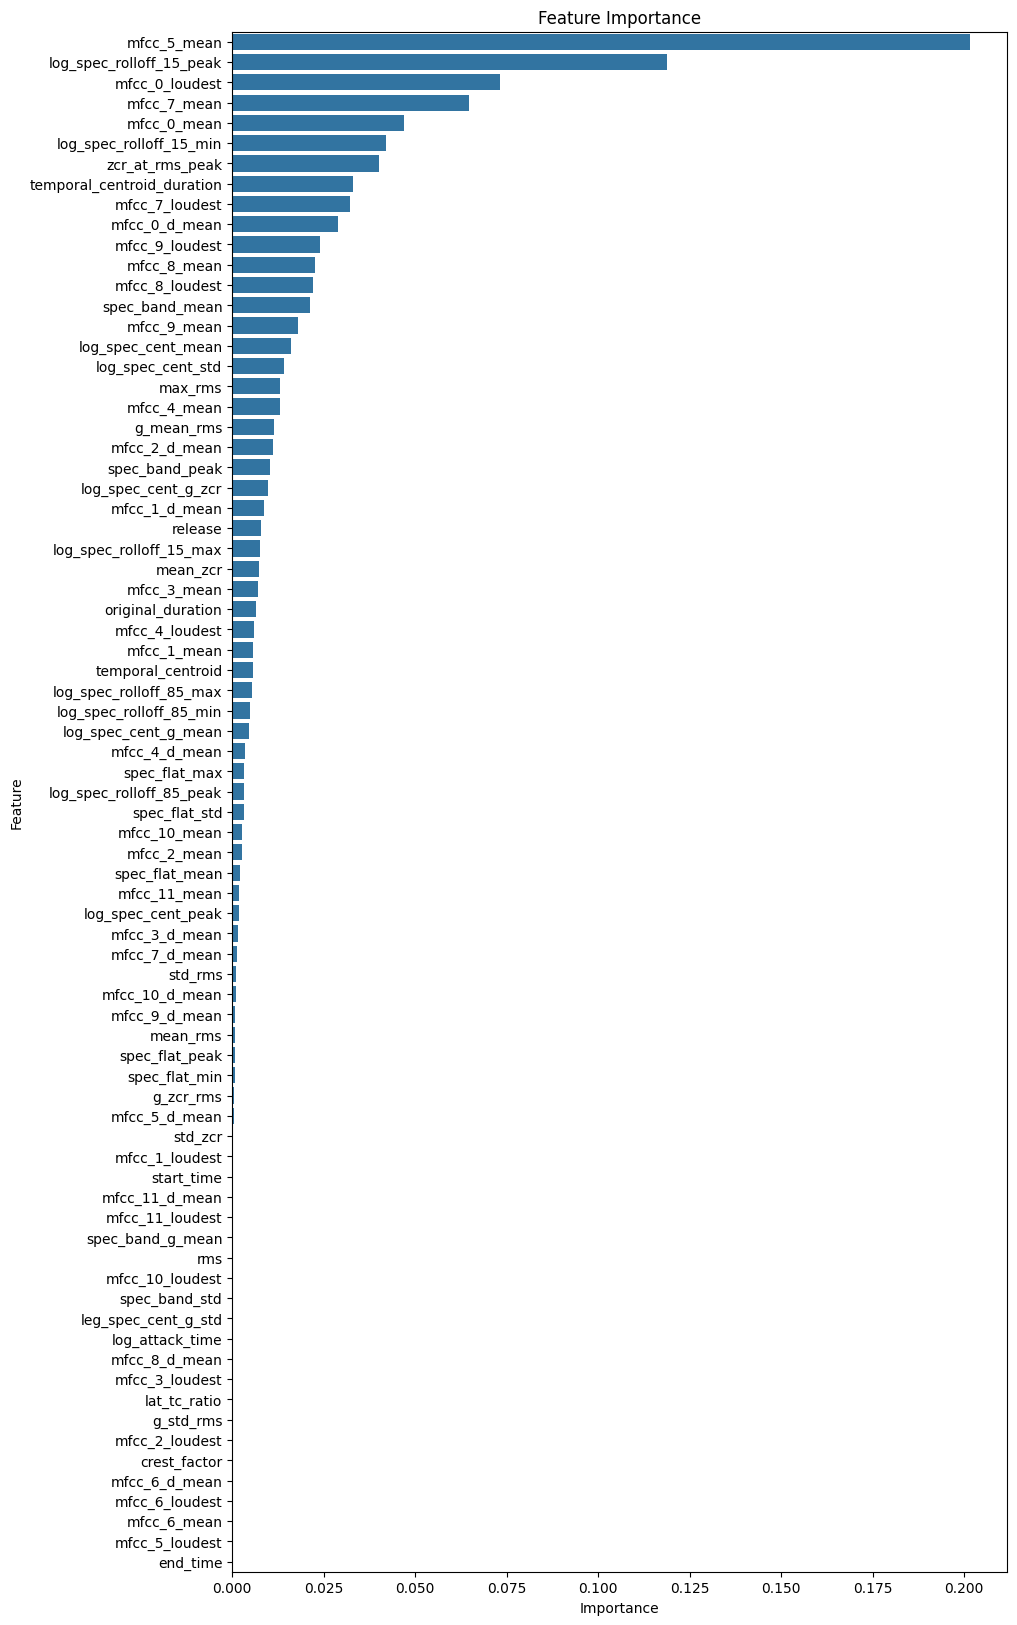

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 20))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()